# Synthetic data

From https://www.kaggle.com/mistag/reverse-engineering-create-clean-gw-signals

* Make a GW wave
* Add to target=0 signals
* Train a denoising model

In [1]:
import numpy as np
import riroriro.inspiralfuns as ins
import riroriro.mergerfirstfuns as me1
import riroriro.matchingfuns as mat
import riroriro.mergersecondfuns as me2
import librosa
import librosa.display
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal
from pathlib import Path
from tqdm.notebook import tqdm


COMP_NAME = "g2net-gravitational-wave-detection"

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/{COMP_NAME}/")
OUTPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_output/{COMP_NAME}/")

In [2]:
# Parameters:
# logMC: system mass (0.0-2.0)
# q: mass ratio (0.1-1.0)
# D: distance (Mpc)
# merger_type: 'BH'=binary black hole merger, 'NS'=binary neutron star merger
# flow: low frequency (Hz)
def gen_gw(logMc=1.4, q=0.8, D=100.0, flow=10.0, merger_type="BH"):
    M, eta = ins.get_M_and_eta(logMc=logMc, q=q)
    start_x = ins.startx(M, flow)
    end_x = ins.endx(eta, merger_type)
    x, xtimes, dt = ins.PN_parameter_integration(start_x, end_x, M, eta)  # 27.7s
    realtimes = ins.inspiral_time_conversion(xtimes, M)
    i_phase, omega, freq = ins.inspiral_phase_freq_integration(x, dt, M)  # 2.7s
    r, rdot = ins.radius_calculation(x, M, eta)  # 28.9s
    A1, A2 = ins.a1_a2_calculation(r, rdot, omega, D, M, eta)  # 4.39s
    i_Aorth, i_Adiag = ins.inspiral_strain_polarisations(A1, A2, i_phase)  # 15.1
    i_amp = ins.inspiral_strain_amplitude(i_Aorth, i_Adiag)  # 4.8s
    i_time = realtimes
    i_omega = omega
    sfin, wqnm = me1.quasi_normal_modes(eta)
    alpha, b, C, kappa = me1.gIRS_coefficients(eta, sfin)
    fhat, m_omega = me1.merger_freq_calculation(wqnm, b, C, kappa)
    fhatdot = me1.fhat_differentiation(fhat)
    m_time = me1.merger_time_conversion(M)
    min_switch_ind = mat.min_switch_ind_finder(i_time, i_omega, m_time, m_omega)  # 25.3
    final_i_index = mat.final_i_index_finder(min_switch_ind, i_omega, m_omega)
    time_offset = mat.time_offset_finder(min_switch_ind, final_i_index, i_time, m_time)
    i_m_time, i_m_omega = mat.time_frequency_stitching(
        min_switch_ind, final_i_index, time_offset, i_time, i_omega, m_time, m_omega
    )
    i_m_freq = mat.frequency_SI_units(i_m_omega, M)
    m_phase = me2.merger_phase_calculation(
        min_switch_ind, final_i_index, i_phase, m_omega
    )
    i_m_phase = me2.phase_stitching(final_i_index, i_phase, m_phase)
    m_amp = me2.merger_strain_amplitude(
        min_switch_ind, final_i_index, alpha, i_amp, m_omega, fhat, fhatdot
    )
    i_m_amp = me2.amplitude_stitching(final_i_index, i_amp, m_amp)
    m_Aorth, m_Adiag = me2.merger_polarisations(final_i_index, m_amp, m_phase, i_Aorth)
    i_m_Aorth, i_m_Adiag = me2.polarisation_stitching(
        final_i_index, i_Aorth, i_Adiag, m_Aorth, m_Adiag
    )
    return (
        np.array(i_m_time),
        np.array(i_m_Aorth),
        np.array(i_m_Adiag),
        np.array(i_m_freq),
    )


def plot_sig(dt, sig1, sig2=None, seg=2.0):
    end = dt[-1]
    start = end - seg
    plt.figure(1)
    plt.plot(dt, sig1)
    peak = np.max(np.abs(sig1))
    plt.axis([start, end, np.min(sig1) - peak / 10, np.max(sig1) + peak / 10])
    if sig2 is not None:
        plt.plot(dt, sig2)
    plt.xlabel("Time (s)")
    plt.ylabel("Strain amplitude")
    
    
def resample(time, sig1, sig2, sr=2048):
    f1 = interp1d(time, sig1)
    f2 = interp1d(time, sig2)
    new_time = np.arange(0, time.max(), 1/sr)
    return new_time, f1(new_time), f2(new_time)    

In [3]:
m_time, m_Aorth, m_Adiag, m_freq = gen_gw(logMc=1.4, q=0.2)  # 2 mins

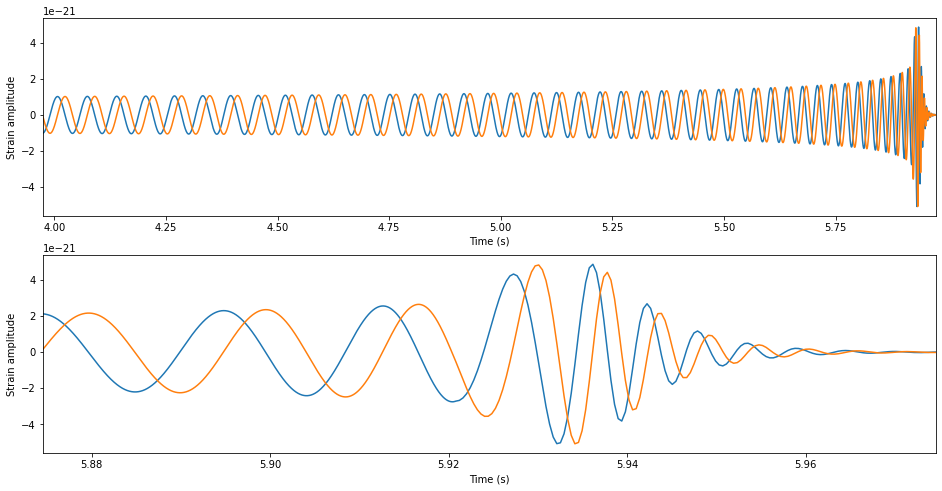

In [4]:
fig = plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
plot_sig(m_time, m_Aorth, m_Adiag, seg=2)
plt.subplot(2, 1, 2)
plot_sig(m_time, m_Aorth, m_Adiag, seg=.1)

In [5]:
m_time.shape, m_Aorth.shape, m_Adiag.shape, m_freq.shape

((1279583,), (1279583,), (1279583,), (1279583,))

In [6]:
SR = 2048

new_time, new_Aorth, new_Adiag = resample(m_time, m_Aorth, m_Adiag, SR)

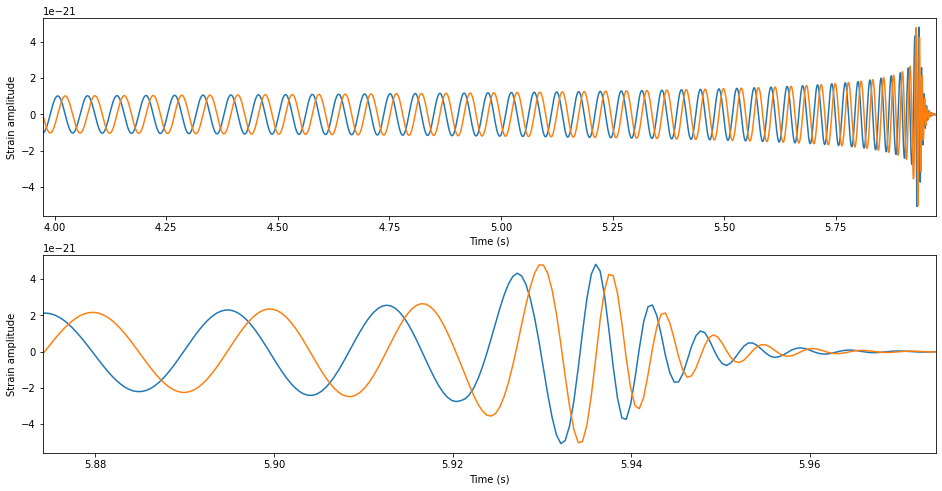

In [7]:
fig = plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
plot_sig(new_time, new_Aorth, new_Adiag, seg=2)
plt.subplot(2, 1, 2)
plot_sig(new_time, new_Aorth, new_Adiag, seg=.1)

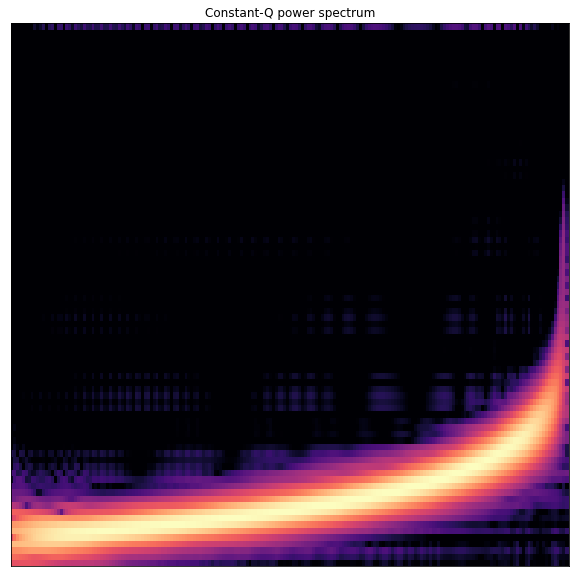

In [8]:
d1 = new_Adiag * signal.tukey(len(new_Adiag), 0.2)

hop_length = 64

C = np.abs(librosa.cqt(d1/np.max(d1), sr=SR, hop_length=hop_length, fmin=8, filter_scale=0.8, bins_per_octave=12))
fig, ax = plt.subplots(figsize=(10,10))
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=SR*2, hop_length=hop_length, bins_per_octave=12, ax=ax)
ax.set_title('Constant-Q power spectrum');

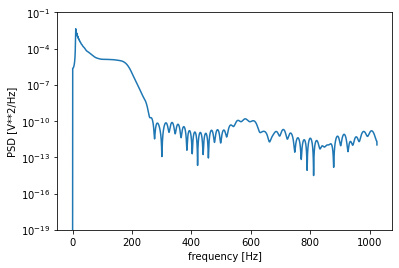

In [9]:
f, Pxx_den = signal.periodogram(new_Adiag / new_Adiag.max(), SR)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-19, 1e-1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Maybe whitening doesn't work because the data is artifacted by the low sample rate?

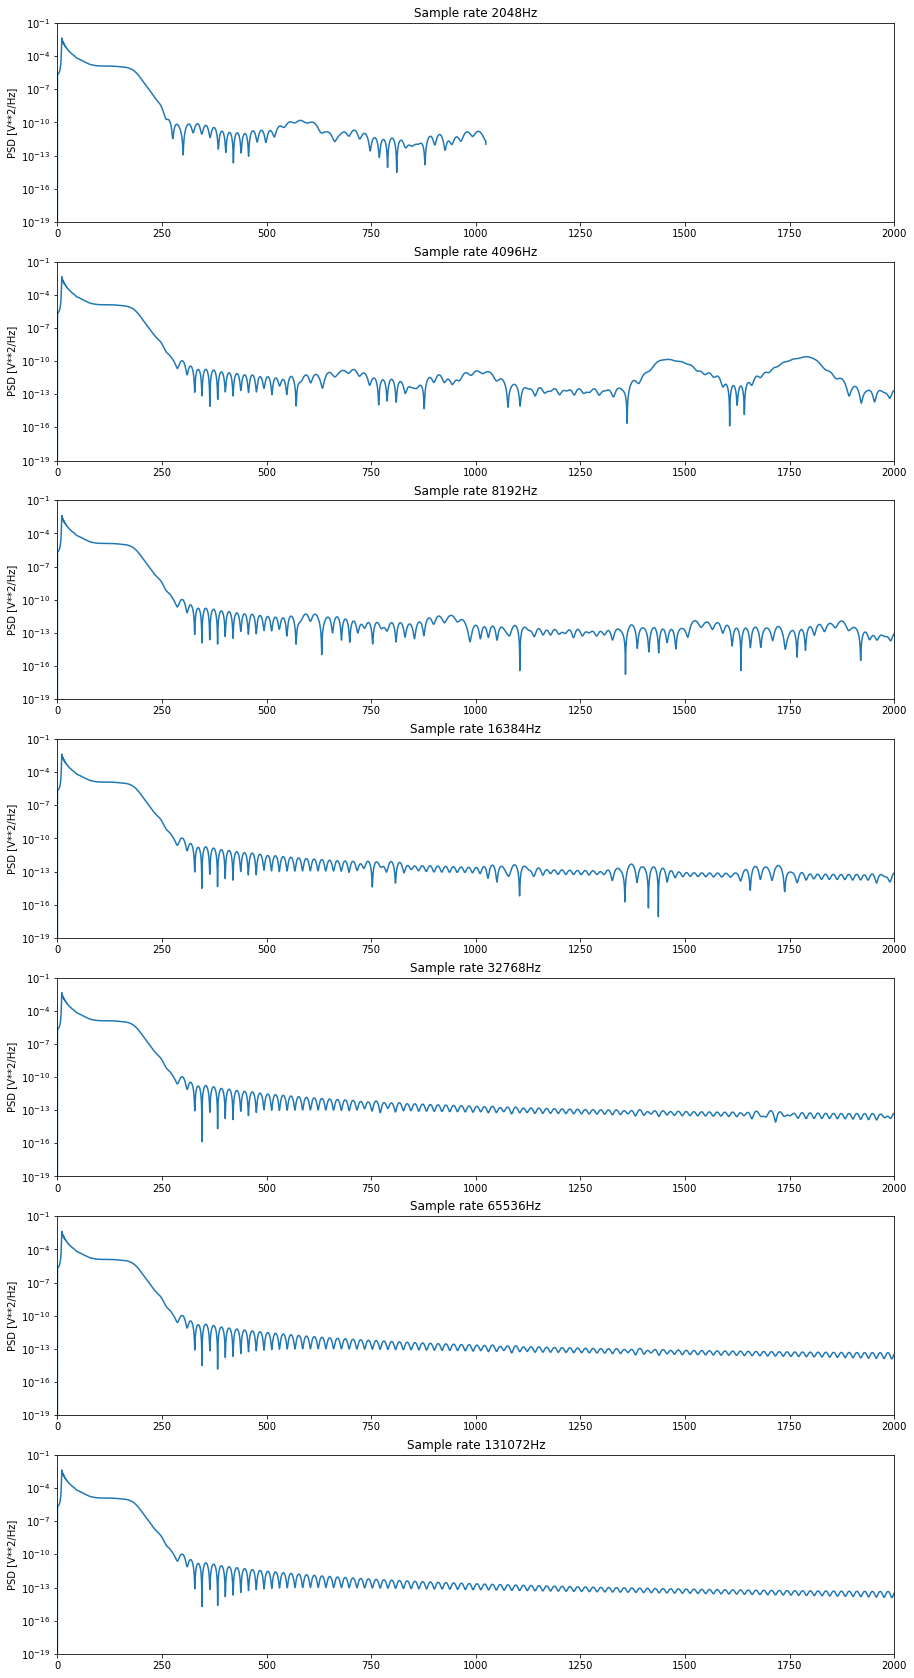

In [10]:
fig, axes = plt.subplots(nrows=7, figsize=(15, 30))

for i in range(1, 8):
    SR = 1024 * 2 ** i
    new_time, new_Aorth, new_Adiag = resample(m_time, m_Aorth, m_Adiag, SR)
    f, Pxx_den = signal.periodogram(new_Adiag / new_Adiag.max(), SR)
    axes[i - 1].semilogy(f, Pxx_den)
    axes[i - 1].set_title(f"Sample rate {SR}Hz")
    axes[i - 1].set_ylim([1e-19, 1e-1])
    axes[i - 1].set_xlim([0, 2000])
#     axes[i - 1].set_xlabel("frequency [Hz]")
    axes[i - 1].set_ylabel("PSD [V**2/Hz]")
#     axes[i - 1].set_xscale('log')

# Generate GW signals

In [11]:
from joblib import Parallel, delayed

def create_signal(args):
    logMc, q, flow = args
#     print(logMc, q, flow)
    m_time, m_Aorth, m_Adiag, m_freq = gen_gw(float(logMc), float(q), flow=float(flow)) 
    new_time, new_Aorth, new_Adiag = resample(m_time, m_Aorth, m_Adiag, 2048)
    data = np.stack([new_time, new_Aorth, new_Adiag])
    np.save(INPUT_PATH / "gw_sim" / f"logmc-{logMc:0.1f}_q-{q:0.1f}_flow-{flow}", data)
#     return None

In [12]:
(INPUT_PATH / "gw_sim").mkdir(exist_ok=True)

params = []

for logMc in np.arange(0.1, 2, 0.1):
    for q in np.arange(0.1, 1, 0.1):
        for flow in np.arange(5, 15, 1):
            params.append((logMc, q, flow))
                          
Parallel(n_jobs=16)(delayed(create_signal)(args) for args in params)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,